# Section 1 of Toy Models of Superposition

In [1]:
import os
import torch
import random
from torch import nn
import matplotlib.pyplot as plt

In [2]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using mps device


### Global variables
Thess are kept the same accross models. They are passed into the training function so it can be easily reused.

<b>Note:</b> the way these are declared could cause confusion in the code. There isn't a dataset that the models are trained on. Each new piece of data is generated randomly durring training. I used terms like epoch to make the code more concrete + easier to read.

In [3]:
NUM_EPOCHS = 10
BATCHS_PER_EPOCH = 1000
BATCH_SIZE = 80
LEARNING_RATE = 1e-3
IMPORTANCE = (0.85 ** torch.arange(0, 5)).to(device)

In [4]:
IMPORTANCE

tensor([1.0000, 0.8500, 0.7225, 0.6141, 0.5220], device='mps:0')

## Defining Model

In [5]:
class ToyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(2, 5), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(5, 1), requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        
    def forward(self, x): # x is 5 * 1
        hidden = self.weights @ x
        final = self.weights.T @ hidden
        final += self.bias
        return self.ReLU(final)

class ImporanceWeightedMSE(nn.Module):
    def __init__(self):
        super(ImporanceWeightedMSE, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0).flatten()
        return sum(sub_total * importance)

In [6]:
def train(model, epochs, total_batchs, batch_size, loss_fn, optimizer, importance, sparsity):
    probability = 1 - sparsity
    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            sparsity_tensor = torch.bernoulli(torch.full((5,1), probability))
            x = torch.rand(batch_size, 5, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("EPHOCH:", epoch + 1, "--> loss:", loss_total / (total_batchs * batch_size))
        loss_total = 0

## Defining Graphing Function (for graphing features)

In [7]:
def graph_model(weights): # wieghts must be on cpu -- does NOT include bias perameters
    plt.figure(dpi=170)
    plt.axis([-1.1, 1.1, -1.1, 1.1])
    
    for i in range(4, -1, -1): # interates through wieghts backwards so more important
        w_i = w[i]             # features are graphed on top of less important ones
        slope = w_i[1]/w_i[0]
        
        b = slope * slope
        n = torch.norm(w_i).item()
        limit = n/torch.sqrt(1 + slope**2).item()

        if w_i[0] < 0:
            x2 = torch.arange(start=0, end=-limit - 1.5, step=-0.0001)
            y2 = x2 * slope
            x = torch.arange(start=0, end=-limit, step=-0.0001)
            y = x * slope
        else:
            x2 = torch.arange(start=0, end=limit + 1.5, step=0.01)
            y2 = x2 * slope
            x = torch.arange(start=0, end=limit, step=0.01)
            y = x * slope
    
        rand_color = (1 - random.random()/2.75, 0.6 - random.random()/2.75, 0.6 - random.random()/2.75)
        lighter_color = (min(1, rand_color[0] + 0.4), rand_color[1] + 0.4, rand_color[2] + 0.4)
    
        plt.plot(x2, y2, '--', color=lighter_color, linewidth=1.5, markeredgecolor='y')
        plt.plot(x, y, '-', color=rand_color, label=str(i), linewidth=1.5, markeredgecolor='y')
    
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.legend()
    plt.show()

## Training 0 Sparsity Model

In [8]:
# IMPORTANCE = torch.arange(1, 0, -0.2).to(device)
SPARSITY = 0.0

model_0_sparsity = ToyModel().to(device)
optimizer = torch.optim.SGD(model_0_sparsity.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_0_sparsity, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

EPHOCH: 1 --> loss: 0.3674908763170242
EPHOCH: 2 --> loss: 0.3352907278060913
EPHOCH: 3 --> loss: 0.3355156872034073
EPHOCH: 4 --> loss: 0.33575162143707277
EPHOCH: 5 --> loss: 0.3363285710334778
EPHOCH: 6 --> loss: 0.336303116440773
EPHOCH: 7 --> loss: 0.3371844743013382
EPHOCH: 8 --> loss: 0.33419558446407316
EPHOCH: 9 --> loss: 0.33403600895404817
EPHOCH: 10 --> loss: 0.33610486328601835


In [9]:
w = model_0_sparsity.weights.T.to('cpu').detach()
print(w)

tensor([[ 9.9082e-01, -1.3085e-01],
        [ 1.2909e-01,  9.9044e-01],
        [ 3.2704e-05, -1.6417e-03],
        [ 9.9601e-04, -7.9669e-04],
        [-7.6083e-04,  2.8816e-03]])


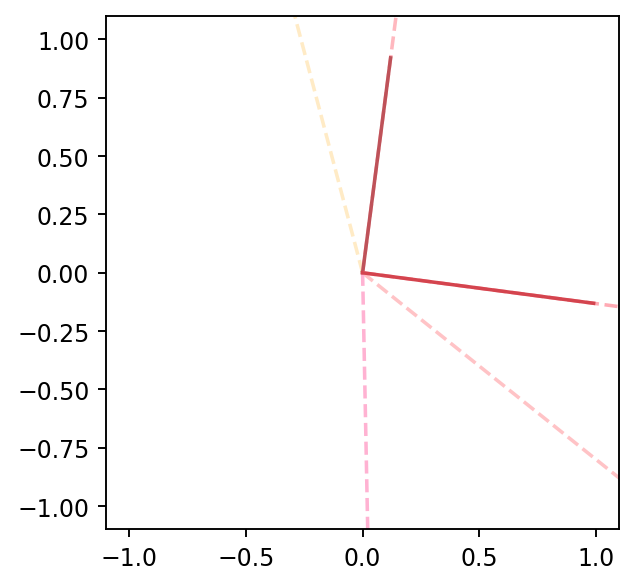

In [10]:
graph_model(w)

## Training 80% Sparsity Model

In [11]:
# IMPORTANCE = torch.arange(1, 0, -0.2).to(device)
SPARSITY = 0.80

model_80_sparsity = ToyModel().to(device)
optimizer = torch.optim.SGD(model_80_sparsity.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_80_sparsity, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

EPHOCH: 1 --> loss: 0.08853765359559347
EPHOCH: 2 --> loss: 0.05608529095028849
EPHOCH: 3 --> loss: 0.057871005175971366
EPHOCH: 4 --> loss: 0.049820796852576676
EPHOCH: 5 --> loss: 0.05034659166983329
EPHOCH: 6 --> loss: 0.053275675445096565
EPHOCH: 7 --> loss: 0.053820839779730886
EPHOCH: 8 --> loss: 0.04888902397805359
EPHOCH: 9 --> loss: 0.053817579563037725
EPHOCH: 10 --> loss: 0.05419258014038205


In [12]:
w = model_80_sparsity.weights.T.to('cpu').detach()
print(w)

tensor([[ 0.7944,  0.6563],
        [-0.6396,  0.7882],
        [-0.7884, -0.6101],
        [ 0.6288, -0.7854],
        [ 0.0098,  0.0171]])


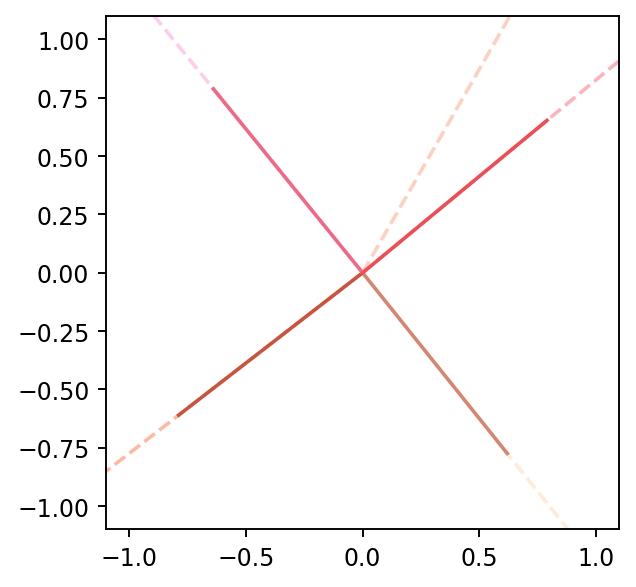

In [13]:
graph_model(w)

## Training 90% Sparsity Model

In [14]:
SPARSITY = 0.90

model_90_sparsity = ToyModel().to(device)
optimizer = torch.optim.SGD(model_90_sparsity.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_90_sparsity, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

EPHOCH: 1 --> loss: 0.06302862630952295
EPHOCH: 2 --> loss: 0.027036057748514076
EPHOCH: 3 --> loss: 0.024325990720507115
EPHOCH: 4 --> loss: 0.024759172610612903
EPHOCH: 5 --> loss: 0.014436591604351998
EPHOCH: 6 --> loss: 0.021386758717149495
EPHOCH: 7 --> loss: 0.021081714575365187
EPHOCH: 8 --> loss: 0.025800589429959653
EPHOCH: 9 --> loss: 0.02117215457521379
EPHOCH: 10 --> loss: 0.020344798235222696


In [15]:
w = model_90_sparsity.weights.T.to('cpu').detach()
print(w)

tensor([[ 1.0268,  0.4440],
        [-1.1106,  0.1934],
        [-0.4796, -1.0127],
        [-0.2000,  1.0669],
        [ 0.7084, -0.7463]])


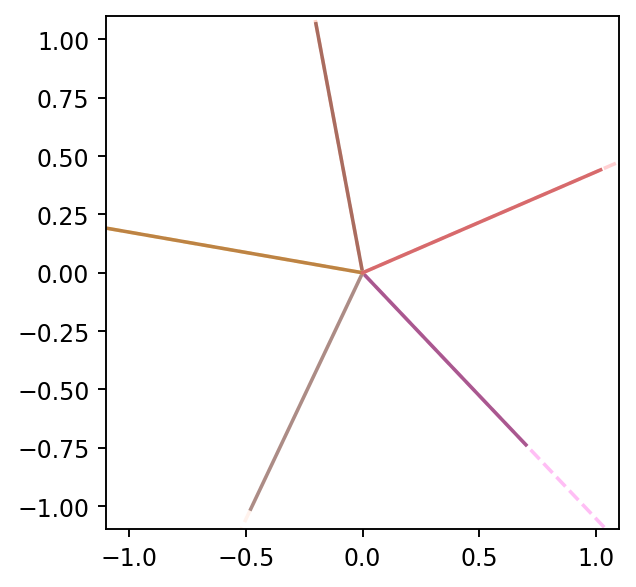

In [16]:
graph_model(w)

In [17]:
IMPORTANCE

tensor([1.0000, 0.8500, 0.7225, 0.6141, 0.5220], device='mps:0')